In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from sklearn.datasets import fetch_openml

# Introduction

Recall the classical bias variance tradeoff: 
- A model with too low complexity might not be able to interpolate the training data. This is **underfitting**, there is too much **biais**. 
- A model with too high complexity might interpolate the training data with no generaliyation to the test data. This is **overfitting**, there is too much **variance**.  

This typically lead to the following learning curves:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/1920px-Bias_and_variance_contributing_to_total_error.svg.png" alt="Alt text" width="700"  style="background-color: white" > 

The double descent is an intersesting phenomemon where beyond a certain point of model complexity, test performance may improve again, resulting in the so-called "double descent" pattern.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/50/Double_descent.png" alt="Alt text" width="700"  style="background-color: white" > 

The double descent phenomenom has recently gained interest in the Machine Learning community as it contributes to lighten the behaviour of Deep neural Networks.


Note that double descent occurs on a very specific setting. Denoting $p$ the number of parameters in the model (i.e. its complexity) and $n$ the number of points in the dataset we can defien the **relative complexity** of the model as

$$ C = \frac{p}{n}$$

Double descent typically occurs when $p \to \infty$ (very large model), $n \to \infty$ (very large dataset) but $C$ is fixed. 

This setting is very common in deep learning but it has also been extensively studied in the literature at the lens of Kernel Ridgeless Regression. 

In this practical, we will approximate Kernel Ridgeless Regression with $p$ Random Fourier Features and observe double descent occur as $p \to \infty$.

# Random Fourier Features

Recall that for any kernel $k(x,y)$ there exist a feature map $\phi : \mathbf{R}^d \mapsto \mathcal{H}$ such that 

$$ k(x,y) = \langle \phi(x), \phi(y) \rangle$$

Usually, we never compute $\phi(x)$ has it can be very complicated (typically of infinite dimension). Instead we prefer to use the representer theorem which tells us that most problem can be solved by computing the Gram matrix $K$ of the train set:

$$ K_{i,j} = k(x_i,x_j) $$

The problem is that this matrix has $n^2$ entries which makes it unpractical (or even impossible) to compute/store for large dataset (as considered in this practical).

Does it mean that kernel methods do not apply to large datasets ? No ! This is where Random Fourier Features (or others kernel approximations techniques) comes into play.

The goal is now to find a feature map $\psi : \mathbf{R}^d \mapsto \mathbf{R}^p$ that **can** be computed (unlike to $\phi$) such that 

$$ k(x,y) = \langle \phi(x), \phi(y) \rangle \approx \langle \psi(x), \psi(y) \rangle$$

Let us consider a kernel of the following form:

$$ k(x,y) = h(x - y)$$

For instance this is the case of the Gaussian kernel for $h(y) = \exp(y^2/\sigma^2)$.

It is a standard results from Fourier transform theory that (for well behaved functions $h$)

$$ h(y) = \int_w p(w) \exp( i \langle y, w \rangle ) dw$$

if $p(w)$ is set to be the Fourier transform of $h$. Assuming that $p$ is normaliyed to be a probability distribution we get that 

$$ k(x,y) = E_w[ \exp(i \langle x - y, w \rangle) ]$$

For $ w \sim p(w)$. Since k is real we have even remove the the imaginary part to get that 

$$ k(x,y) = E_w[ \cos(\langle x - y, w \rangle) ]$$



Q1) Lets $b \sim \text{Unif}(0,2\pi)$ prove that 

$$E_w[ \cos(\langle x - y, w \rangle) ] = 2 E_{w,b}[ \cos(\langle x, w  \rangle+ b) \cos(\langle y, w \rangle+ b ) ]$$

\begin{align*}
E_w[ \cos(\langle x - y, w \rangle) ] &= \mathbb{E}_{w \sim \mathcal{P}}[\cos(w^T x - w^T y)] \\
&= \mathbb{E}_{w \sim \mathcal{P}}[\cos(w^T x) \cos(w^T y) + \sin(w^T x) \sin(w^T y)] \\
&= \mathbb{E}_{w \sim \mathcal{P}} \left[ \frac{1}{2\pi} \int_0^{2\pi} 2 \cos(w^T x + b) \cos(w^T y + b) db \right] \\
&= \mathbb{E}_{w \sim \mathcal{P}, b \sim \mathcal{U}(0, 2\pi)} [\sqrt{2} \cos(w^T x + b) \sqrt{2} \cos(w^T y + b)] \\
&= 2 E_{w,b}[ \cos(\langle x, w  \rangle+ b) \cos(\langle y, w \rangle+ b ) ] \\
\end{align*}

In other words:

- The expression $E_w[ \cos(\langle x - y, w \rangle) ]$ is expanded by first using the trigonometric identity for $\cos(a - b) = \cos(a) \cos(b) + \sin(a) \sin(b)$. This allows the expectation to be written as:
  $$
  \mathbb{E}_{w \sim \mathcal{P}}[\cos(w^T x) \cos(w^T y) + \sin(w^T x) \sin(w^T y)].
  $$

- Next, we express the terms as an integral over a uniform random variable $b \in [0, 2\pi]$, yielding:
  $$
  \mathbb{E}_{w \sim \mathcal{P}} \left[ \frac{1}{2\pi} \int_0^{2\pi} 2 \cos(w^T x + b) \cos(w^T y + b) db \right].
  $$

- Finally, this is rewritten using $b \sim \mathcal{U}(0, 2\pi)$, leading to the final result:
  $$
  2 \mathbb{E}_{w,b}[ \cos(\langle x, w \rangle + b) \cos(\langle y, w \rangle + b)].
  $$

Applying the standard Monte Carlo approximation to the previous results we get that:

$$ k(x,y) \approx \frac{2}{p} \sum_{i=1}^p \cos(\langle x, w_i  \rangle+ b_i) \cos(\langle y, w_i \rangle+ b_i )$$

For some $w_i \sim p(w)$ and $b_i \sim \text{Unif}(0,2\pi)$ .

Q2) Define the feature map $\psi : \mathbf{R}^d \mapsto \mathbf{R}^p$ such that 

$$ k(x,y) \approx \langle \psi(x), \psi(y) \rangle$$

From the Monte Carlo approximation of the kernel:

$$
\hat{k}_D(x, y) = \frac{2}{p} \sum_{i=1}^{p} \cos(\langle x, w_i \rangle + b_i) \cos(\langle y, w_i \rangle + b_i),
$$

the corresponding feature map $\psi(x)$ can be identified as:

$$
\psi(x) = \left( \sqrt{\frac{2}{p}} \cos(\langle x, w_1 \rangle + b_1), \dots, \sqrt{\frac{2}{p}} \cos(\langle x, w_p \rangle + b_p) \right) \in \mathbb{R}^p.
$$

Thus, the kernel approximation becomes $k(x, z) \approx \langle \psi(x), \psi(z) \rangle$.

Q3) Now lets write the code to compute an approximation of the Gram Matrix $K$ for the Gaussian kernel

$$ k(x,y) = \exp\left( - \frac{1}{2} (x-y)^2 \right)$$

Note that for the Gaussian Kernel you should sample $w_i$ from $N(0,1)$ as the Fourier transform of a Gaussian is also a Gaussian.

In [2]:
def Compute_Exact_Gaussian_Kernel(X):

    norms = np.linalg.norm(X, axis=1)**2
    dot = X@X.T
    squared_euclidian_distances = norms[:, None] - 2 * dot + norms[None, :]

    K = np.exp(-squared_euclidian_distances/2)

    return K

def Compute_RFF_Gaussian_Kernel(X, p):
    n, d = X.shape

    # Sample W from a normal distribution N(0,1)
    W = np.random.normal(0, 1, size=(p, d))

    # Sample b, it must be a matrix of size p x 1
    b = np.random.uniform(0, 2 * np.pi, size=(p,))

    # Compute psi(X), it must be a matrix of size n x p
    psiX = np.sqrt(2 / p) * np.cos(X @ W.T + b)

    K = psiX @ psiX.T

    return K


You can now play with the following code to see how well the kernel is approximated depending on the number of random fourier features $p$.

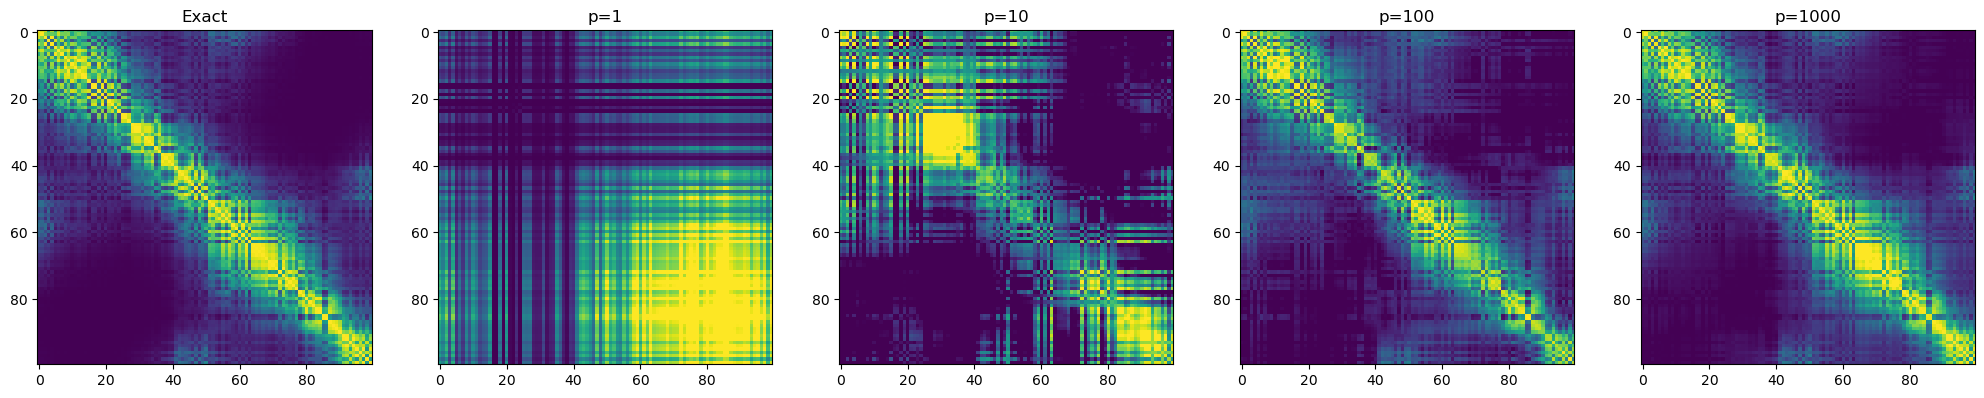

In [3]:
X, t = make_s_curve(noise=0.05, random_state=0)
sorting = np.argsort(t)
X = X[sorting]

# Add the values of p you want to test
p_list = [1, 10, 100, 1000]

p_list = [None] + p_list

fig, axes = plt.subplots(1, len(p_list), figsize=(len(p_list) * 5, 5))

for p in p_list:
    ax = axes[p_list.index(p)]

    if p is None:
        K = Compute_Exact_Gaussian_Kernel(X)
        ax.set_title(f"Exact")
    else:
        K = Compute_RFF_Gaussian_Kernel(X, p)
        ax.set_title(f"p={p}")

    ax.imshow(K, vmin=0, vmax=1)

# Kernel Ridge Regression

Recall the formulation of Ridge Regression :

\begin{equation*}
\min_{w \in \mathbb{R}^d} \frac{1}{n}\sum_{i=1}^n (\langle w, x_i \rangle  - y_i)^2 + \lambda ||w||_2^2
\end{equation*}

whose optimal weight is $$w^* = (X^T X + \lambda I_d)^{-1}X^T y $$

And the kerneliyed variant:

\begin{equation*}
\min_{f \in \mathcal{H}} \frac{1}{n}\sum_{i=1}^n ( \langle f, \phi(x_i) \rangle  - y_i)^2 + \lambda ||f||_\mathcal{H}^2
\end{equation*}

In the previous practical we applied the representer theorem to exactly solve this problem.  Instead, we now propose to use the Random Fourier Feature approximation build in the previous part :

\begin{equation*}
\min_{w \in \mathbb{R}^p} \frac{1}{n}\sum_{i=1}^n ( \langle w, \psi(x_i) \rangle  - y_i)^2 + \lambda ||f||_\mathcal{H}^2
\end{equation*}

This is equivalent to a standard Ridge Regression! Thus the optimal weight is

$$ w^* = (\psi(X)^T \psi(X) + \lambda I_d)^{-1} \psi(X)^T y $$

Q4) Lets code this model

In [4]:
class RFF_KRR:
    def __init__(self, p=1, lbda=0.1):
        self.p = p
        self.lbda = lbda

    def fit(self, X, y):
        # Sample W and b
        n, d = X.shape

        # Sample W, it must be a matrix of size p x d
        self.W = np.random.normal(0, 1, size=(self.p, d))
        # Sample W, it must be a matrix of size p x 1
        self.b = np.random.uniform(0, 2 * np.pi, size=self.p)

        # Send to feature space
        psiX = np.sqrt(2 / self.p) * np.cos(X @ self.W.T + self.b)

        # Center the data
        self.mean_x = psiX.mean(axis=0)
        psiX = psiX - self.mean_x

        self.mean_y = y.mean()
        y = y - self.mean_y

        # Use np.linalg.solve or np.linalg.lstsq (more stable)
        # self.w = np.linalg.solve(psiX.T @ psiX + self.lbda * np.eye(self.p), psiX.T @ y)
        self.w = np.linalg.lstsq(psiX.T @ psiX + self.lbda * np.eye(self.p), psiX.T @ y, rcond=None)[0]

    def predict(self, X):
        # Send to feature space
        psiX = np.sqrt(2 / self.p) * np.cos(X @ self.W.T + self.b)

        # Center the data
        psiX = psiX - self.mean_x

        # Make predictions
        y_pred = psiX @ self.w + self.mean_y

        return y_pred

You can now play with following code to test your model

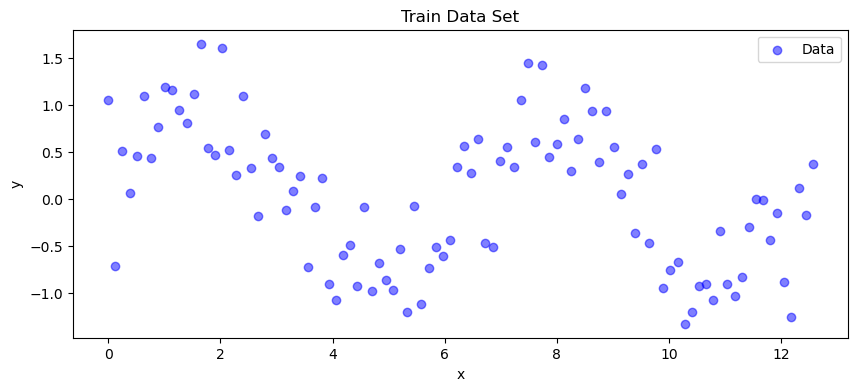

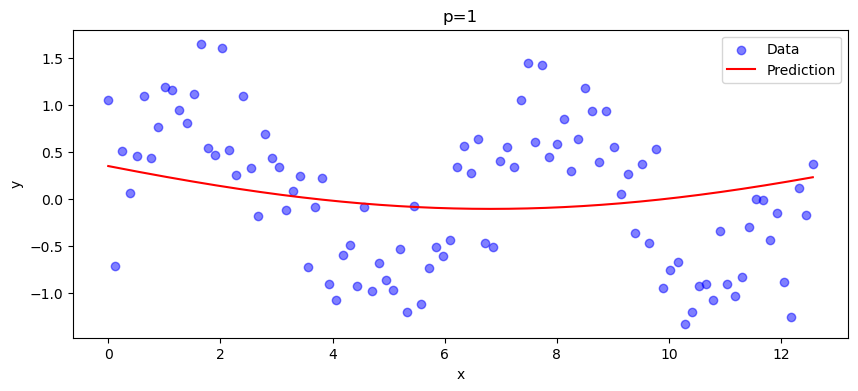

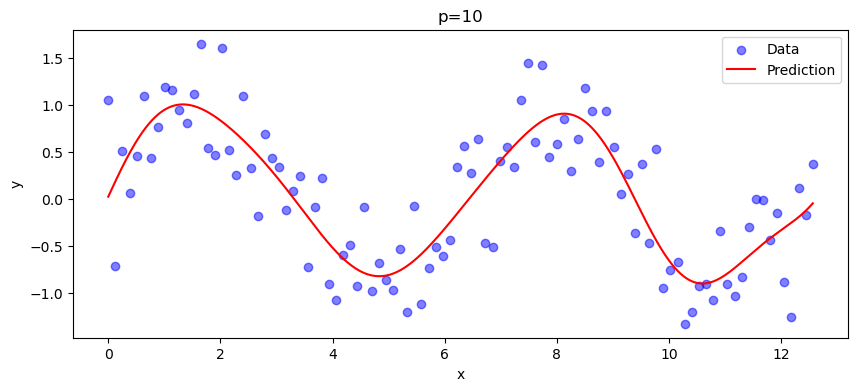

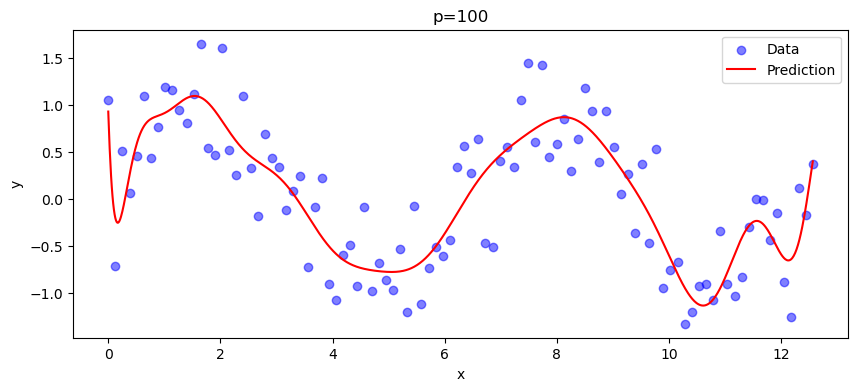

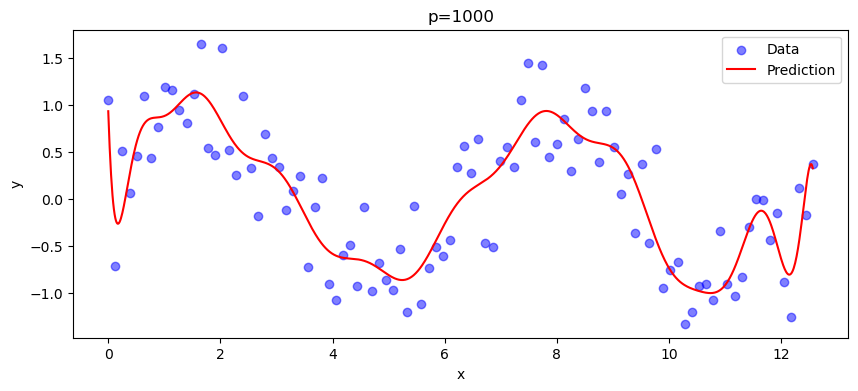

In [5]:
f = lambda x: np.sin(x)
X_train = np.linspace(0, 4 * np.pi, 100).reshape(-1, 1)
y_train = f(X_train) + np.random.normal(0, 0.5, X_train.shape)
X_test = np.linspace(0, 4 * np.pi, 1000).reshape(-1, 1)

plt.figure(figsize=(10, 4))
plt.scatter(X_train, y_train, color="blue", label="Data", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train Data Set")
plt.legend()
plt.show()

# No regulariyation
lbda = 0.0
# Add the values of p you want to test
p_list = [1, 10, 100, 1000]

for p in p_list:
    model = RFF_KRR(p=p, lbda=lbda)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 4))
    plt.scatter(X_train, y_train, color="blue", label="Data", alpha=0.5)
    plt.plot(X_test, y_pred, color="red", label="Prediction")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"p={p}")
    plt.legend()
    plt.show()

# Double Descent

Let us now consider a larger dataset to see if we can observe double descent.

In [6]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784", version=1, parser="auto")
X, y = mnist["data"], mnist["target"]

# Keep only classes 3 and 7
X = X[(y == "3") | (y == "7")]
y = y[(y == "3") | (y == "7")]
y = (y == "7").astype(int)

# Normaliye the data
X = X / 255.0
X = X - X.mean(axis=0)

# Split the data into train and test
n_train = 12000
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12000, 784) (2434, 784)
(12000,) (2434,)


Rembember that KRR with Random Fourier Features as $p$ parameters where $p$ is the number of random projection. 

For instance lets fix $p = 100$ so that our model can fit fast.

The train set that we just downloaded is of size $n_{\text{max}} = 12 000$, let's try to truncate it artifically to a smaller size $n$ so that we can compute the performances for differents values of the  relative complexity $C = p/n$.



In [7]:
def troncate_train_set(X_train, y_train, p, C):
    '''
    Truncate the train set to n samples
    '''

    n = int(p / C)

    assert n <= X_train.shape[0], f'{p} parameters and complexity {C} requires a train set of size {n} which is larger than the max train set of size {X_train.shape[0]}'

    X_train_truncated = X_train[:n]
    y_train_truncated = y_train[:n]

    return X_train_truncated, y_train_truncated

def Compute_MSE(p, lbda, C):
    # Truncate Data
    X_train_truncated, y_train_truncated = troncate_train_set(X_train, y_train, p, C)

    # Define Model
    model = RFF_KRR(p=p, lbda=lbda)

    # Fit Model
    model.fit(X_train_truncated, y_train_truncated)

    # Get the predictions
    y_pred = model.predict(X_test)

    # Compute the Mean Squared Error
    mse = np.mean((y_pred - y_test) ** 2)

    return mse

You can now play with the following code to explore in which regimes does double descent occurs. For the default parameters you should get a nice double descent. 

Try to increase $\lambda$ until the double descent disappear. Why does it disappear ?

As $\lambda$ increases, the regularization term grows stronger, preventing overfitting by constraining the model’s capacity. This reduces variance and forces the model to behave like a simpler one, smoothing the error curve. As a result, the sharp intermediate increase that characterizes double descent disappears, and the model no longer experiences the overfitting phase that causes the peak.

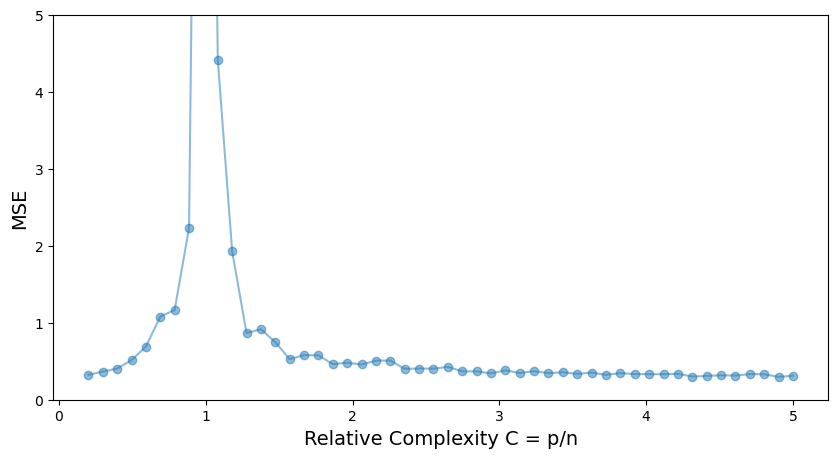

In [8]:
# Higher values might cause problems due to the naive implementation of the RFF_KRR class
p = 100
# Try with no regularization at first, you can try other values later
lbda = 1e-6
Cmin = 0.2
Cmax = 5

C_list = np.linspace(Cmin, Cmax, 50)
scores = np.array([Compute_MSE(p=p, lbda=lbda, C=C) for C in C_list])

plt.figure(figsize=(10, 5))
plt.scatter(C_list, scores, alpha=0.5)
plt.plot(C_list, scores, alpha=0.5)
plt.xlabel("Relative Complexity C = p/n", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.ylim(0, min(np.max(scores), 5))
plt.show()